# 4. Sentiment Analysis

In [1]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch

from afinn import Afinn
from collections import Counter
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

c:\Users\andre\miniforge3\envs\marketweb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style("darkgrid")

In [3]:
df_ending_comments = pd.read_csv("../data/comments_graph_ending_final.csv")
df_ending_comments.head()

,parent,child,text_comment,comment_id,submission_id,subreddit,created_utc,score,depth,parent_comment_id,submission_author,is_submitter
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.,esfm2ec,c7ekxv,attackontitan,2019-06-30 23:17:54,398,1,NaN,joaopaulofoo,False
1,joaopaulofoo,Jdep11,As a anime only viewer I was completely blown ...,esg3e19,c7ekxv,attackontitan,2019-07-01 02:47:48,353,1,NaN,joaopaulofoo,False
2,joaopaulofoo,zONsObito,Judging from the way the titan in this episode...,esff3t1,c7ekxv,attackontitan,2019-06-30 21:55:26,198,1,NaN,joaopaulofoo,False
3,joaopaulofoo,HOCHIHO,''What's waiting for us on the other side of t...,esfy8wi,c7ekxv,attackontitan,2019-07-01 01:41:01,164,1,NaN,joaopaulofoo,False
4,joaopaulofoo,Norra-T,Does anybody else love the character developme...,esgn0tt,c7ekxv,attackontitan,2019-07-01 07:18:38,142,1,NaN,joaopaulofoo,False


### Setting things up

In [4]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess_with_emoticons(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    if len(tokens) > 512:
        return tokens[:512]
    return tokens

In [5]:
df_ending_comments["tokens"] = df_ending_comments["text_comment"].apply(preprocess_with_emoticons, args=(True,))
df_ending_comments.head()

,parent,child,text_comment,comment_id,submission_id,subreddit,created_utc,score,depth,parent_comment_id,submission_author,is_submitter,tokens
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.,esfm2ec,c7ekxv,attackontitan,2019-06-30 23:17:54,398,1,NaN,joaopaulofoo,False,"[armin, mikasa, and, eren, have, finally, seen..."
1,joaopaulofoo,Jdep11,As a anime only viewer I was completely blown ...,esg3e19,c7ekxv,attackontitan,2019-07-01 02:47:48,353,1,NaN,joaopaulofoo,False,"[as, a, anime, only, viewer, i, was, completel..."
2,joaopaulofoo,zONsObito,Judging from the way the titan in this episode...,esff3t1,c7ekxv,attackontitan,2019-06-30 21:55:26,198,1,NaN,joaopaulofoo,False,"[judging, from, the, way, the, titan, in, this..."
3,joaopaulofoo,HOCHIHO,''What's waiting for us on the other side of t...,esfy8wi,c7ekxv,attackontitan,2019-07-01 01:41:01,164,1,NaN,joaopaulofoo,False,"[', ', what's, waiting, for, us, on, the, othe..."
4,joaopaulofoo,Norra-T,Does anybody else love the character developme...,esgn0tt,c7ekxv,attackontitan,2019-07-01 07:18:38,142,1,NaN,joaopaulofoo,False,"[does, anybody, else, love, the, character, de..."


In [6]:
mean_count = df_ending_comments["tokens"].apply(len).mean()
print(mean_count)

37.93130534133105


### Text preprocessing

In [7]:
stop = stopwords.words('english')
additional_sw = [
    'episode', # We do not care, as we will remove also the numbers.
]
stop += additional_sw
lemmatizer = WordNetLemmatizer()

def preprocessing(tokens):
    # 1. Number and punctuation removal
    notext_regex = r'[^A-Za-z]'
    tokens = [re.sub(notext_regex, "", token) for token in tokens if re.sub(notext_regex, "", token)]
    # 2. Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # 3. Stopword removal
    tokens = [token for token in tokens if token not in stop]

    return tokens

df_ending_comments["preproc_tokens"] = df_ending_comments["tokens"].apply(preprocessing)

In [8]:
stop = stopwords.words('english')
additional_sw = [
    'episode', # We do not care, as we will remove also the numbers.
]
stop += additional_sw
lemmatizer = WordNetLemmatizer()

def preprocessing(tokens):
    # 1. Stopword removal
    tokens = [token for token in tokens if token not in stop]
    # 2. Number and punctuation removal
    notext_regex = r'[^A-Za-z]'
    tokens = [re.sub(notext_regex, "", token) for token in tokens if re.sub(notext_regex, "", token)]
    # 3. Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

df_ending_comments["preproc_tokens"] = df_ending_comments["tokens"].apply(preprocessing)

In [9]:
sentences = (list(itertools.chain(df_ending_comments["preproc_tokens"])))
flat_list = [item for sublist in sentences for item in sublist]
c = Counter(flat_list)
c.most_common(20)

[('eren', 4007),
 ('titan', 3141),
 ('like', 2815),
 ('think', 1627),
 ('would', 1565),
 ('one', 1514),
 ('season', 1504),
 ('really', 1408),
 ('see', 1310),
 ('time', 1257),
 ('people', 1251),
 ('zeke', 1146),
 ('get', 1122),
 ('even', 1112),
 ('know', 1062),
 ('also', 1054),
 ('ending', 1005),
 ('good', 990),
 ('manga', 982),
 ('still', 975)]

### Sentiment Analysis: AFINN

In [10]:
afinn = Afinn()
# We must use unprocessed text
df_ending_comments["afinn"] = df_ending_comments["text_comment"].apply(afinn.score)
df_ending_comments.head()

,parent,child,text_comment,comment_id,submission_id,subreddit,created_utc,score,depth,parent_comment_id,submission_author,is_submitter,tokens,preproc_tokens,afinn
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.,esfm2ec,c7ekxv,attackontitan,2019-06-30 23:17:54,398,1,NaN,joaopaulofoo,False,"[armin, mikasa, and, eren, have, finally, seen...","[armin, mikasa, eren, finally, seen, sea]",0.0
1,joaopaulofoo,Jdep11,As a anime only viewer I was completely blown ...,esg3e19,c7ekxv,attackontitan,2019-07-01 02:47:48,353,1,NaN,joaopaulofoo,False,"[as, a, anime, only, viewer, i, was, completel...","[anime, viewer, completely, blown, away, seaso...",6.0
2,joaopaulofoo,zONsObito,Judging from the way the titan in this episode...,esff3t1,c7ekxv,attackontitan,2019-06-30 21:55:26,198,1,NaN,joaopaulofoo,False,"[judging, from, the, way, the, titan, in, this...","[judging, way, titan, moved, forward, made, wa...",0.0
3,joaopaulofoo,HOCHIHO,''What's waiting for us on the other side of t...,esfy8wi,c7ekxv,attackontitan,2019-07-01 01:41:01,164,1,NaN,joaopaulofoo,False,"[', ', what's, waiting, for, us, on, the, othe...","[whats, waiting, u, side, ocean, enemy, right,...",-8.0
4,joaopaulofoo,Norra-T,Does anybody else love the character developme...,esgn0tt,c7ekxv,attackontitan,2019-07-01 07:18:38,142,1,NaN,joaopaulofoo,False,"[does, anybody, else, love, the, character, de...","[anybody, else, love, character, development, ...",0.0


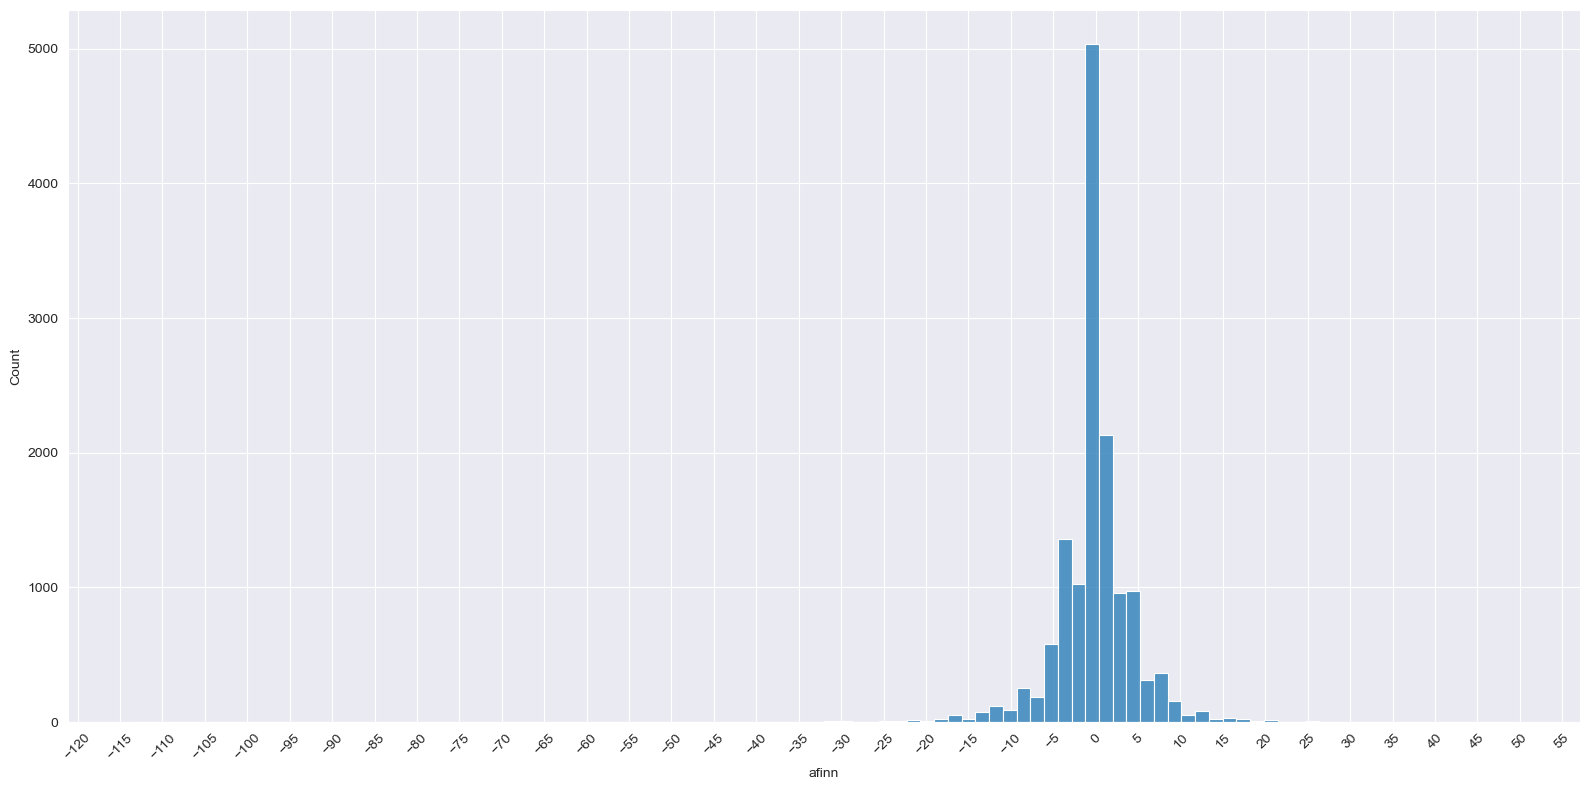

In [11]:
plt.figure(figsize=(16, 8))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)

sns.histplot(df_ending_comments["afinn"], bins=100)
plt.tight_layout()
plt.show()

In [12]:
def label_mapping(score, thres1, thres2):
    if score < thres1:
        return -1
    elif score > thres2:
        return 1
    else:
        return 0
    
df_ending_comments["afinn_labels"] = df_ending_comments["afinn"].apply(label_mapping, args=(0, 0,))
df_ending_comments["afinn_labels"].value_counts()

afinn_labels
 1    5133
-1    4770
 0    4101
Name: count, dtype: int64

In [13]:
df_ending_comments["created_utc"] = df_ending_comments["created_utc"].apply(pd.to_datetime)
df_ending_comments["created_month"] = df_ending_comments["created_utc"].dt.to_period("M")

df_ending_comments = df_ending_comments.sort_values("created_month")

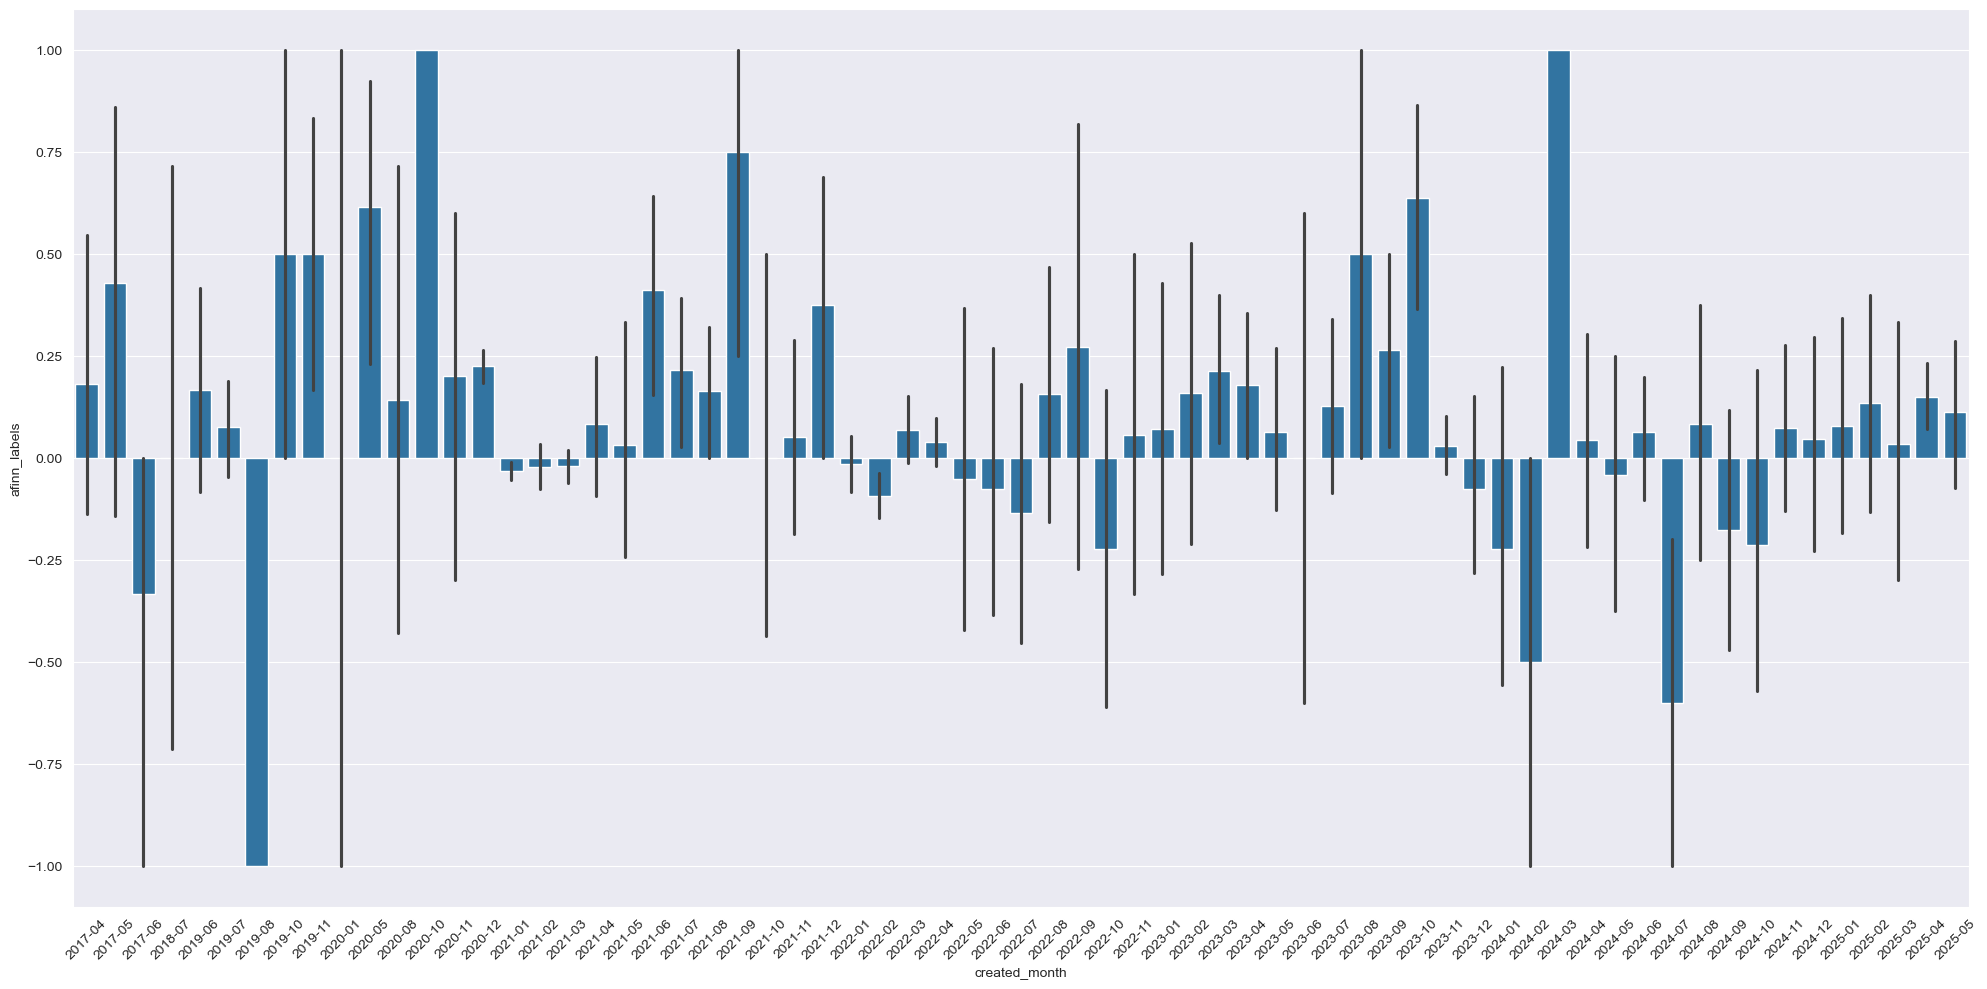

In [14]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)
sns.barplot(df_ending_comments[["created_month", "afinn_labels"]], x="created_month", y="afinn_labels", estimator="mean")

plt.tight_layout()
plt.show()

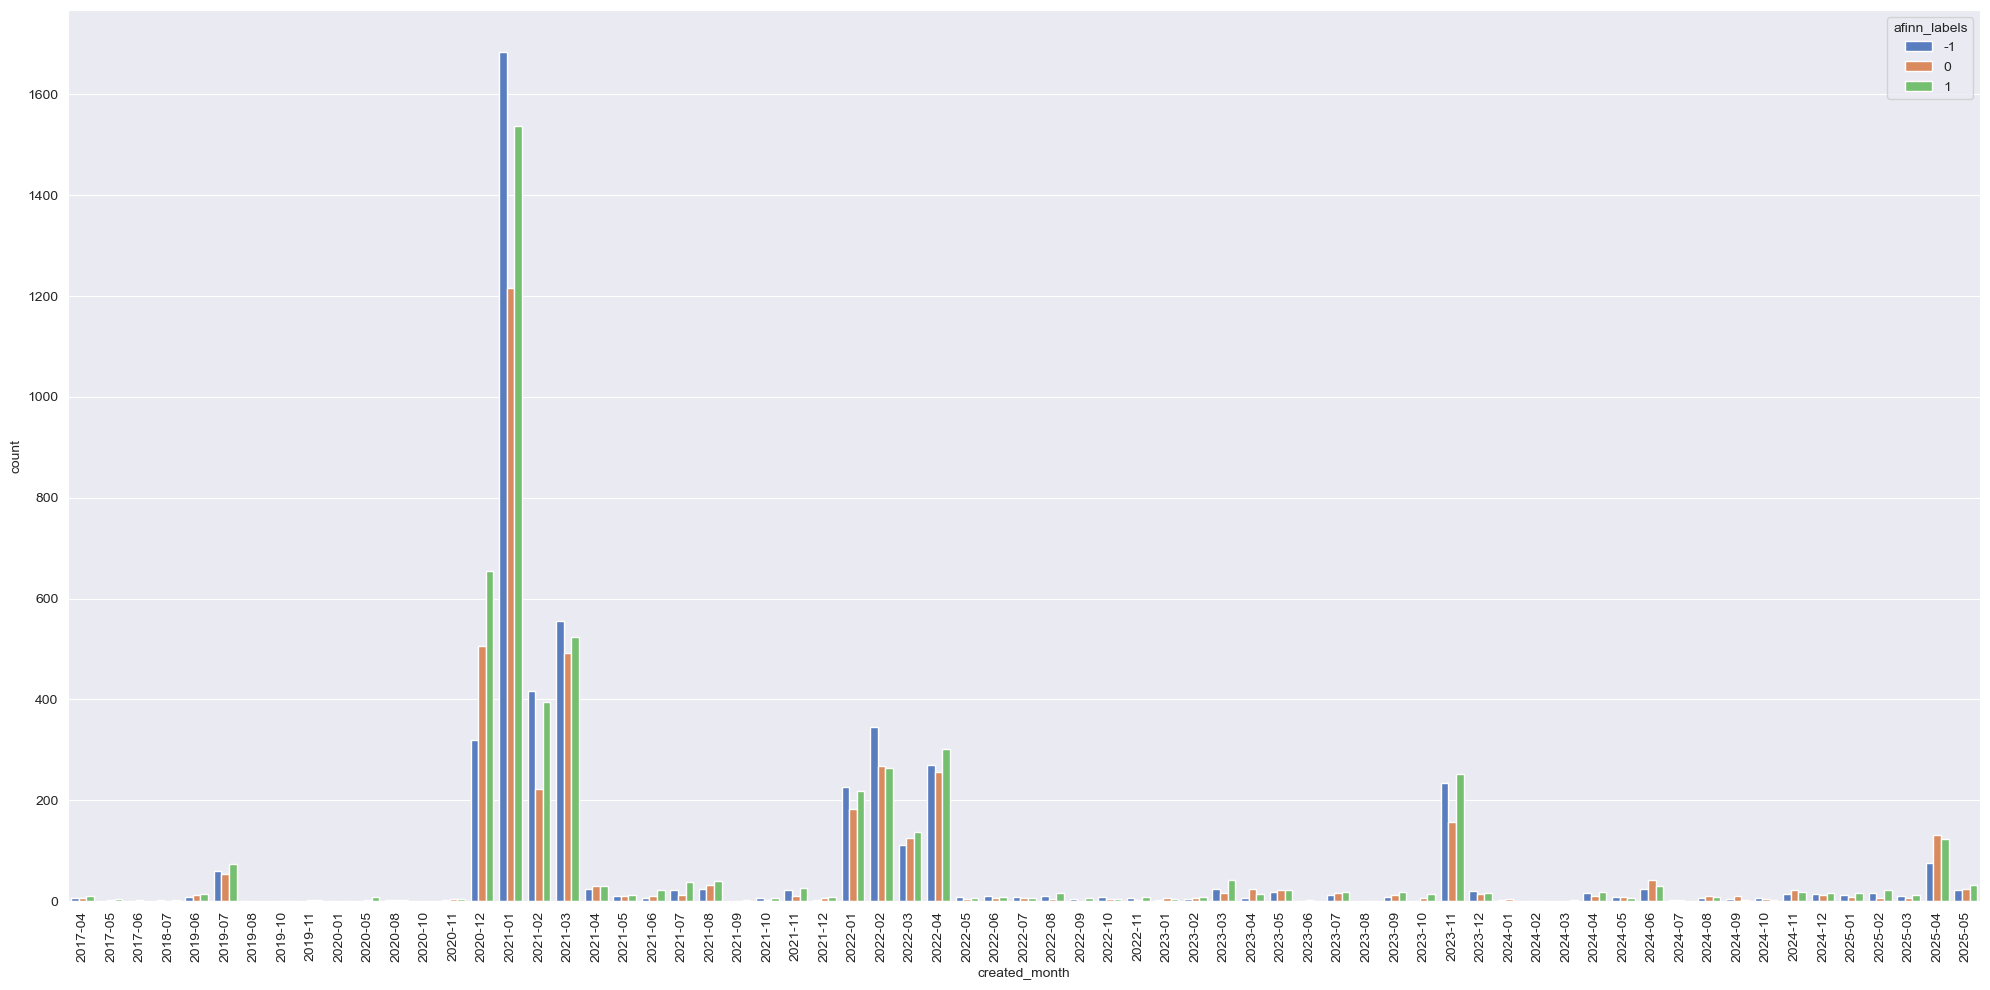

In [15]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=90)
sns.countplot(df_ending_comments, x="created_month", hue="afinn_labels", palette="muted")

plt.tight_layout()
plt.show()

### Sentiment Analysis: nltk opinion lexicon

In [16]:
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

def sentiment_sum(tokens):
    sentiment = 0
    for token in tokens:
        if token in pos_list:
            sentiment += 1
        elif token in neg_list:
            sentiment -= 1
    return sentiment

df_ending_comments["opinion_lexicon"] = df_ending_comments["tokens"].apply(sentiment_sum)
df_ending_comments["opinion_lexicon"]

1486   -1
1487    0
1488    0
1489    0
1482    0
       ..
1694   -5
1695    0
1697   -1
1146    3
1696    0
Name: opinion_lexicon, Length: 14004, dtype: int64

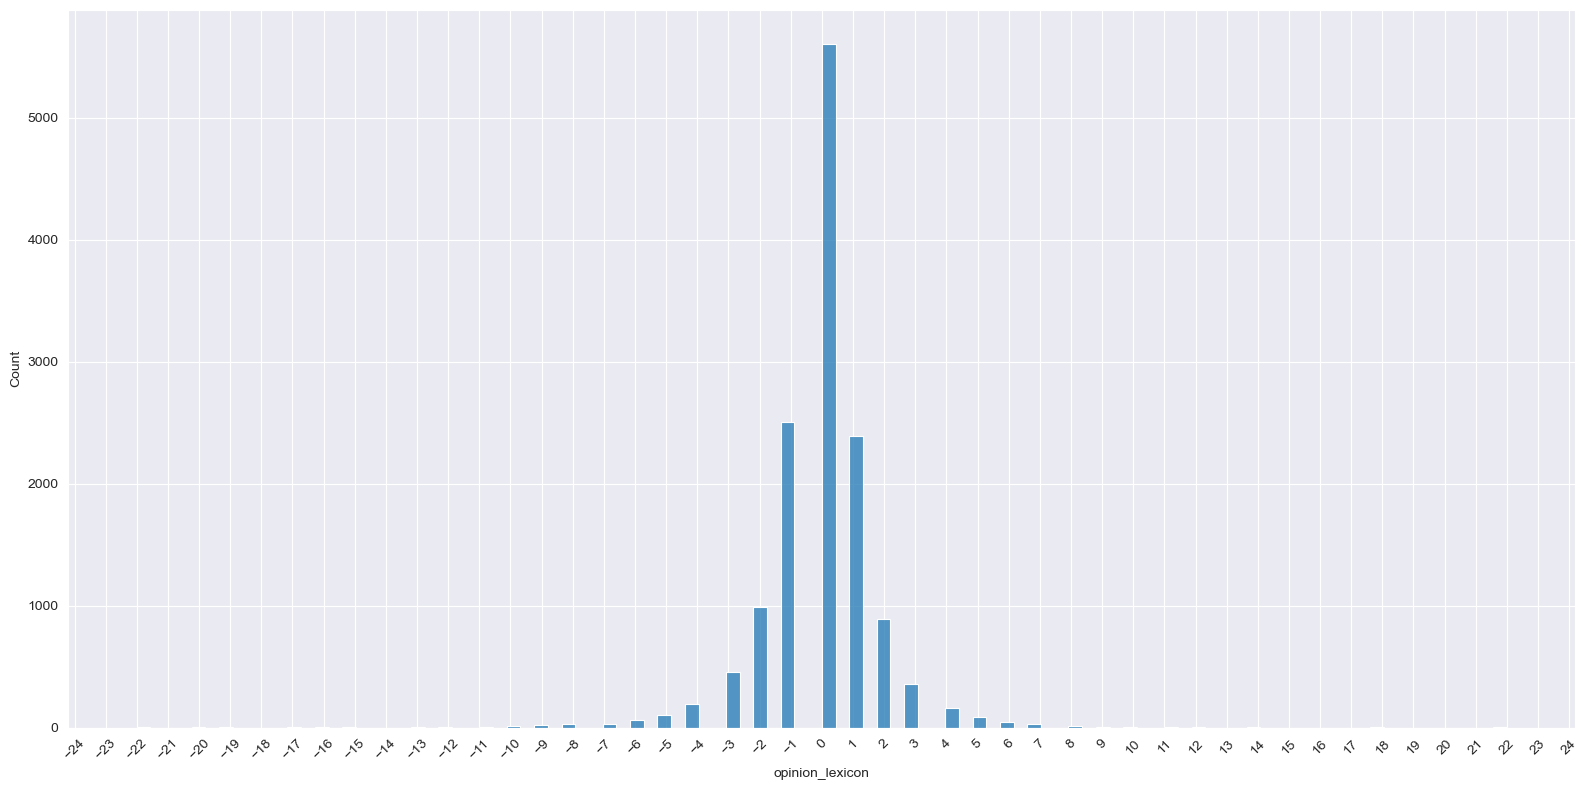

In [17]:
plt.figure(figsize=(16, 8))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)

sns.histplot(df_ending_comments["opinion_lexicon"], bins=100)
plt.tight_layout()
plt.show()

In [18]:
df_ending_comments["opinion_lexicon_labels"] = df_ending_comments["opinion_lexicon"].apply(label_mapping, args=(0, 0,))
df_ending_comments["opinion_lexicon_labels"].value_counts()

opinion_lexicon_labels
 0    5602
-1    4420
 1    3982
Name: count, dtype: int64

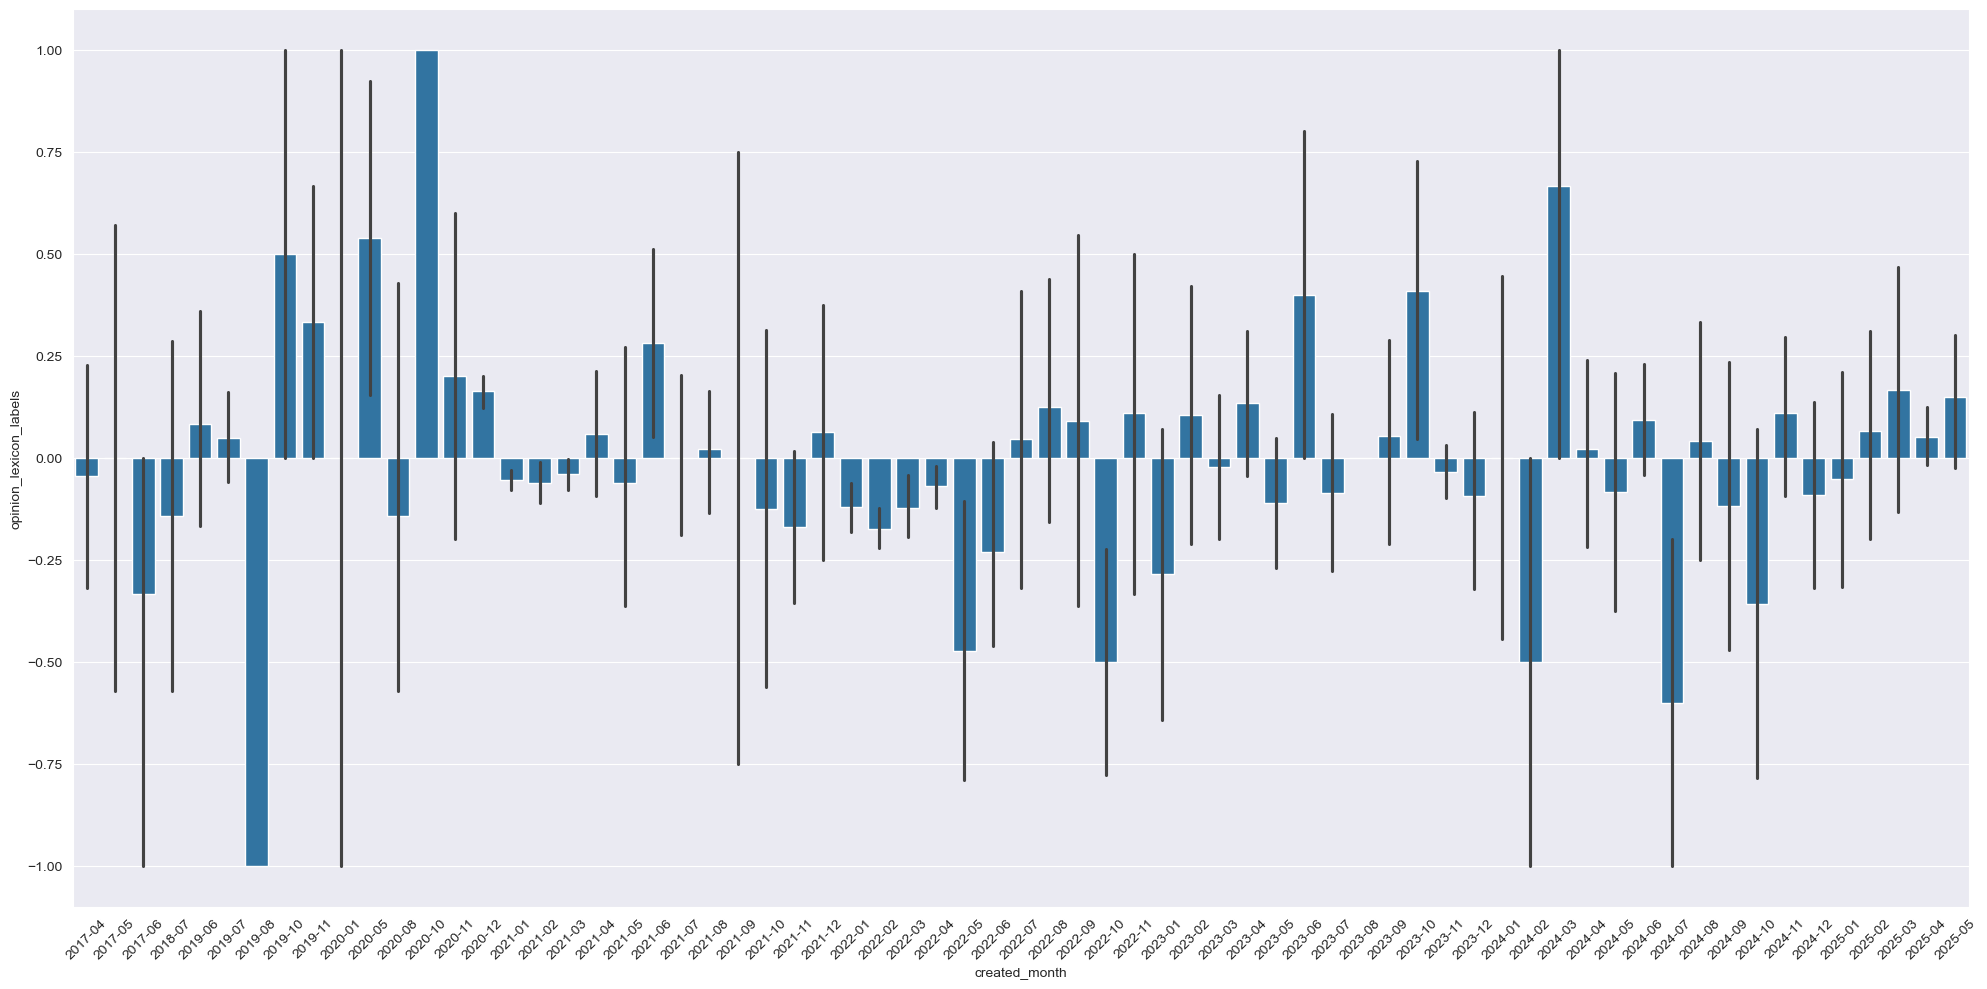

In [19]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)
sns.barplot(df_ending_comments[["created_month", "opinion_lexicon_labels"]], x="created_month", y="opinion_lexicon_labels", estimator="mean")

plt.tight_layout()
plt.show()

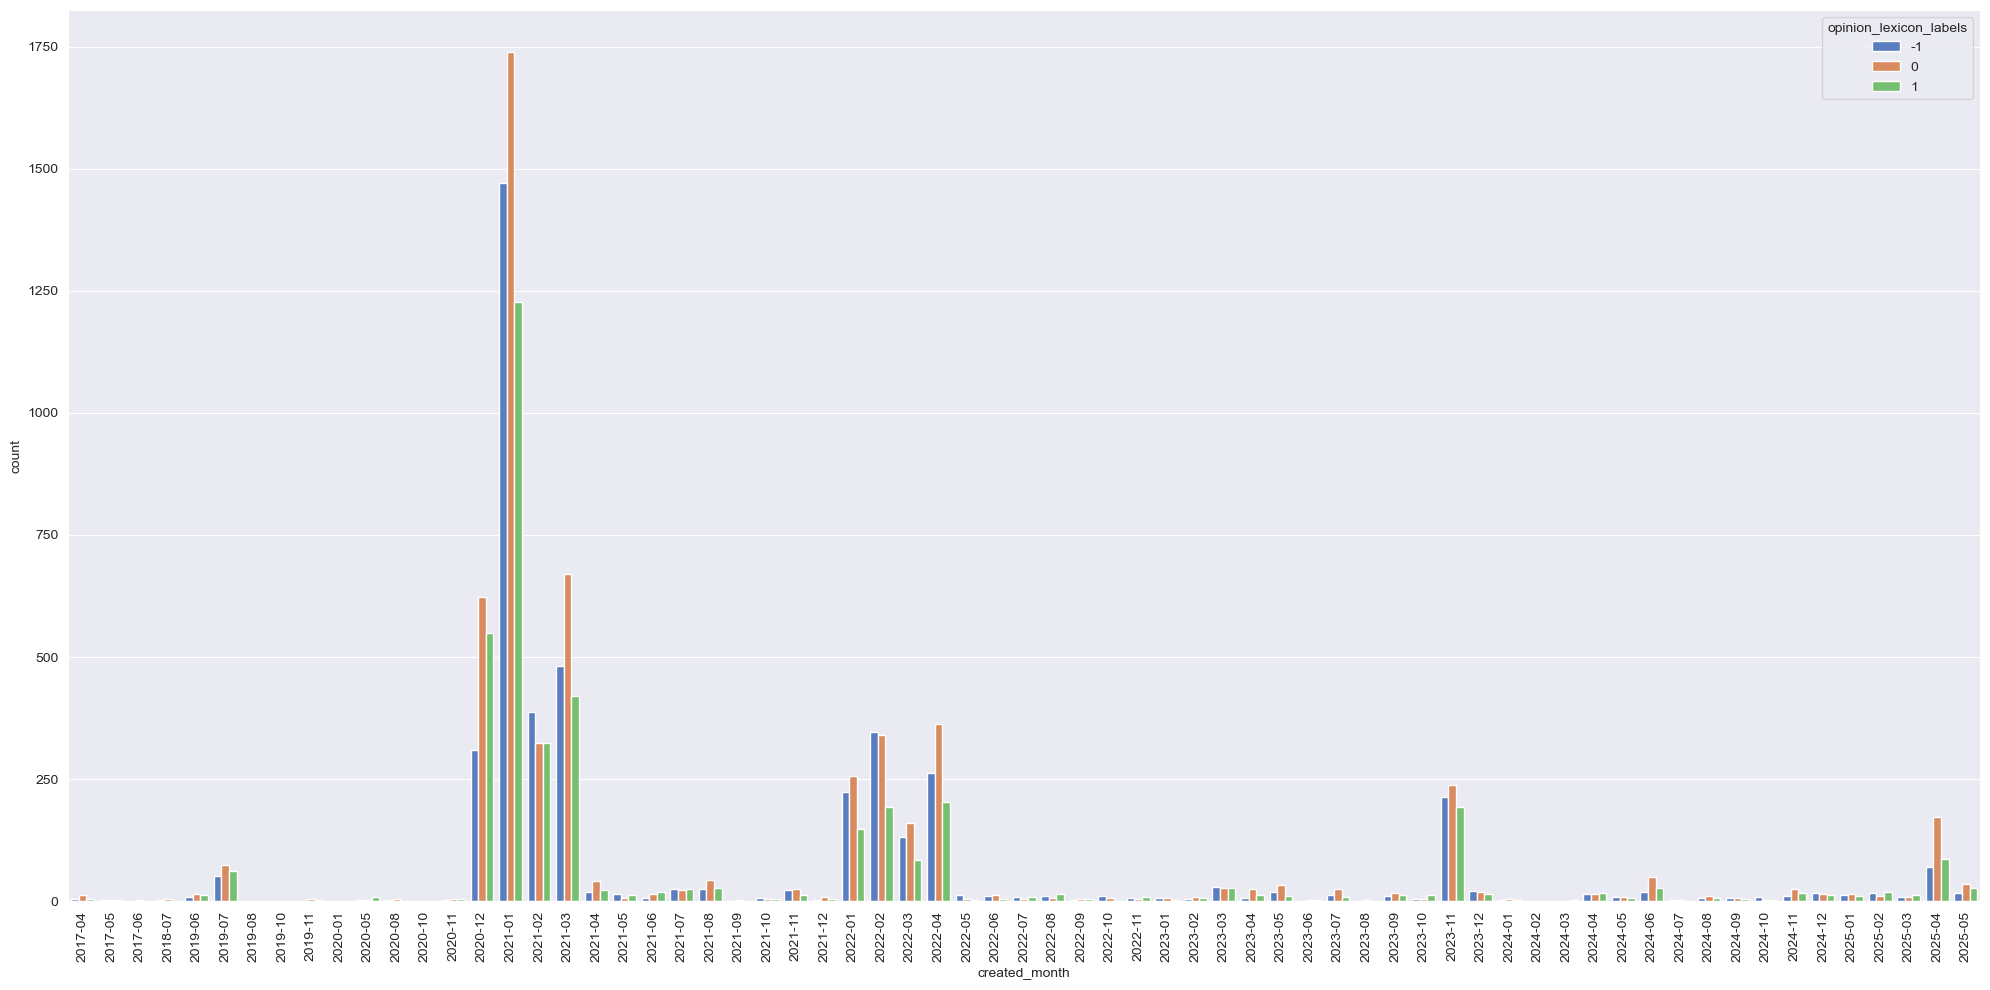

In [20]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=90)
sns.countplot(df_ending_comments, x="created_month", hue="opinion_lexicon_labels", palette="muted")

plt.tight_layout()
plt.show()

### Sentiment Analysis: Vader

In [21]:
sia = SentimentIntensityAnalyzer()

def vader(text):
    sentiment_dict = sia.polarity_scores(text)
    return sentiment_dict["compound"]

df_ending_comments["vader"] = df_ending_comments["text_comment"].apply(vader)
df_ending_comments["vader"]

1486    0.5746
1487   -0.2960
1488    0.1280
1489    0.3802
1482    0.1779
         ...  
1694   -0.9632
1695    0.0000
1697   -0.2263
1146    0.7783
1696   -0.2960
Name: vader, Length: 14004, dtype: float64

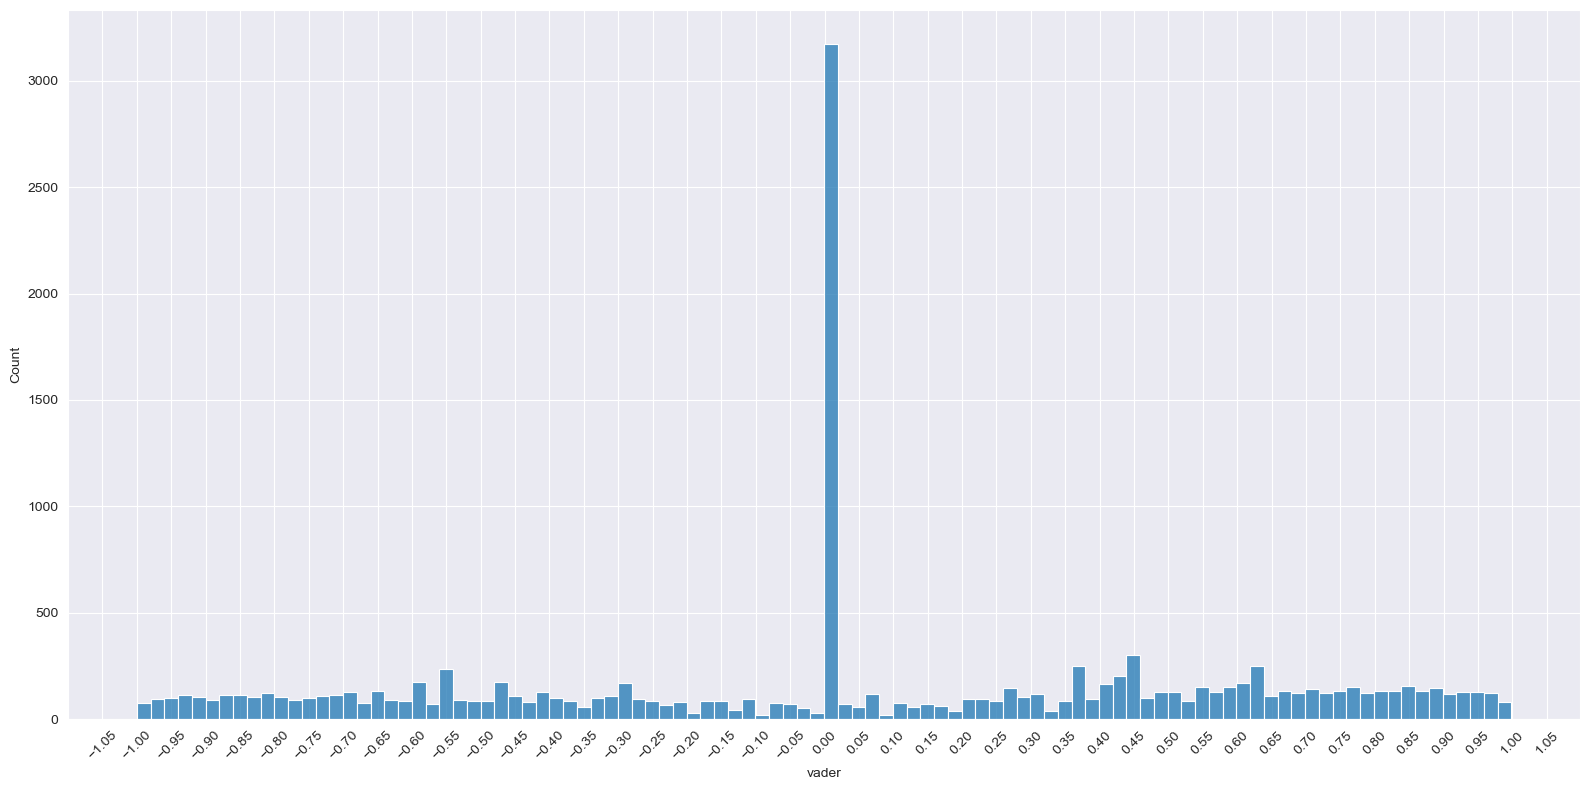

In [22]:
plt.figure(figsize=(16, 8))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)

sns.histplot(df_ending_comments["vader"], bins=100)
plt.tight_layout()
plt.show()

In [23]:
df_ending_comments["vader_labels"] = df_ending_comments["vader"].apply(label_mapping, args=(0, 0,))
df_ending_comments["vader_labels"].value_counts()

vader_labels
 1    5990
-1    4856
 0    3158
Name: count, dtype: int64

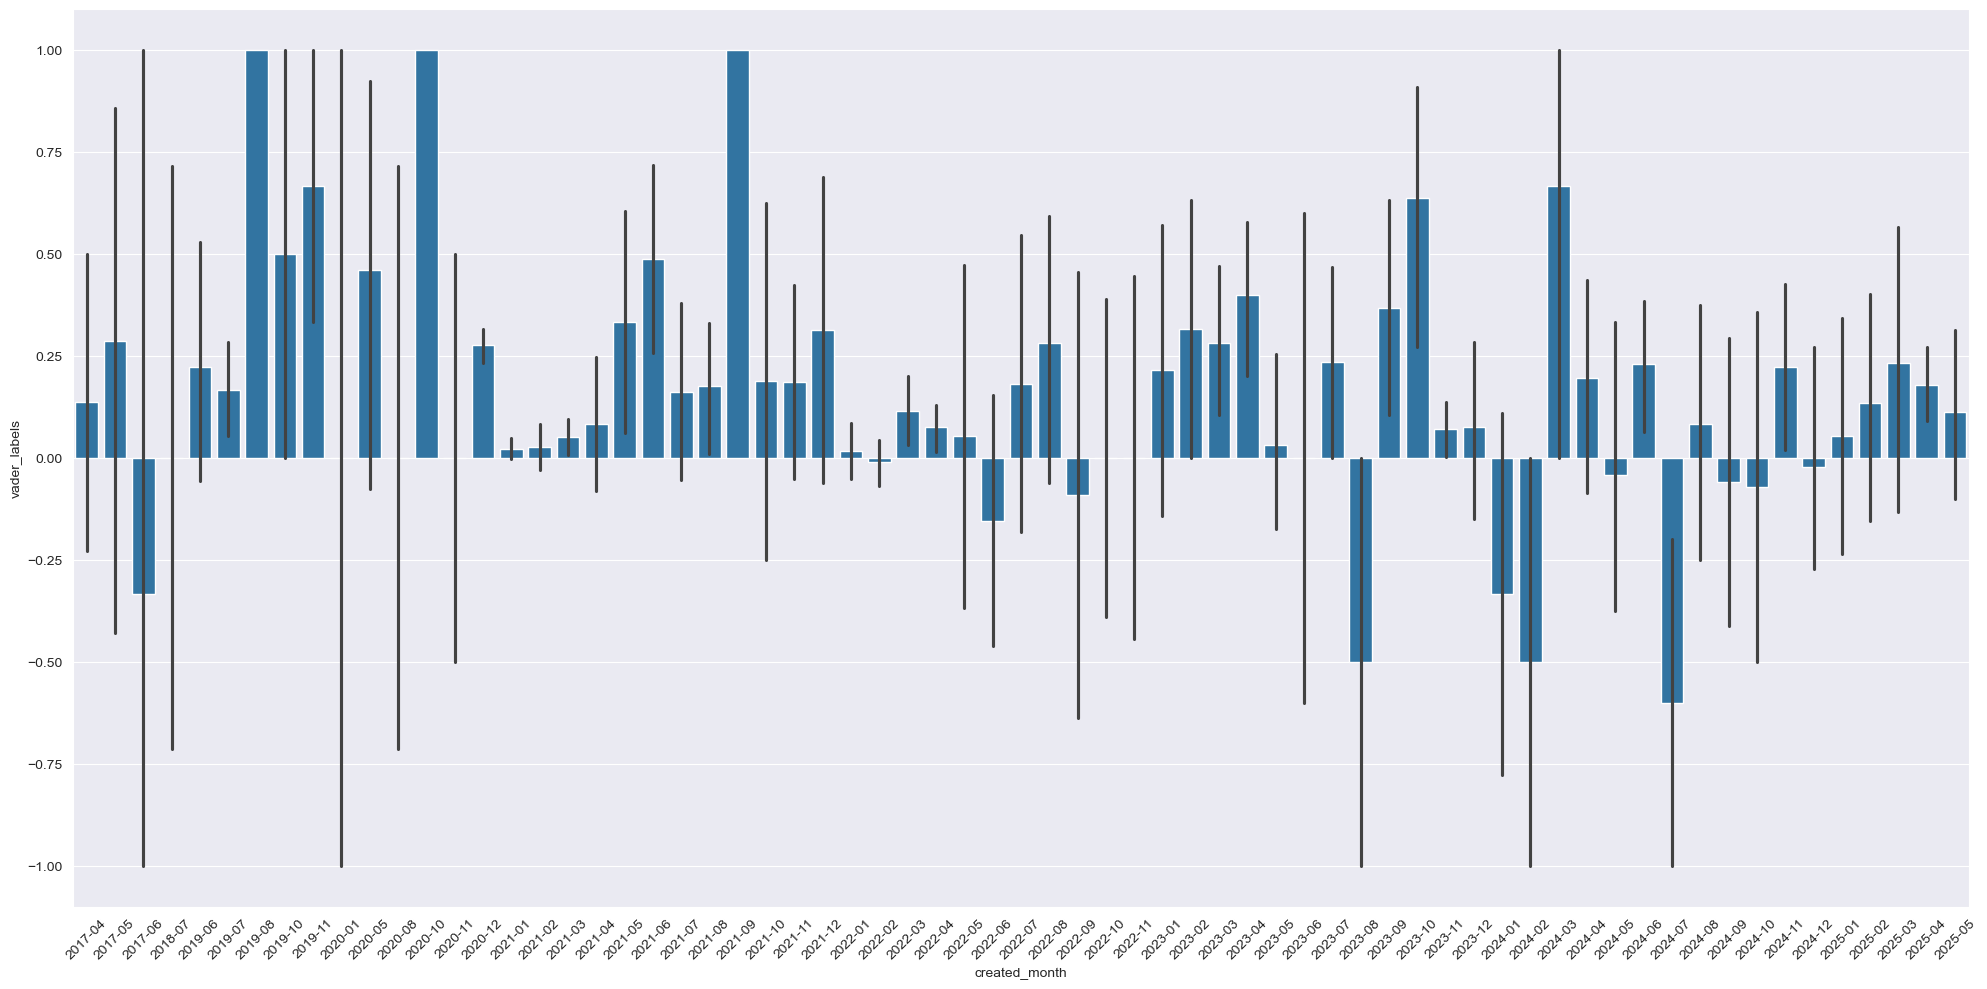

In [24]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)
sns.barplot(df_ending_comments[["created_month", "vader_labels"]], x="created_month", y="vader_labels", estimator="mean")

plt.tight_layout()
plt.show()

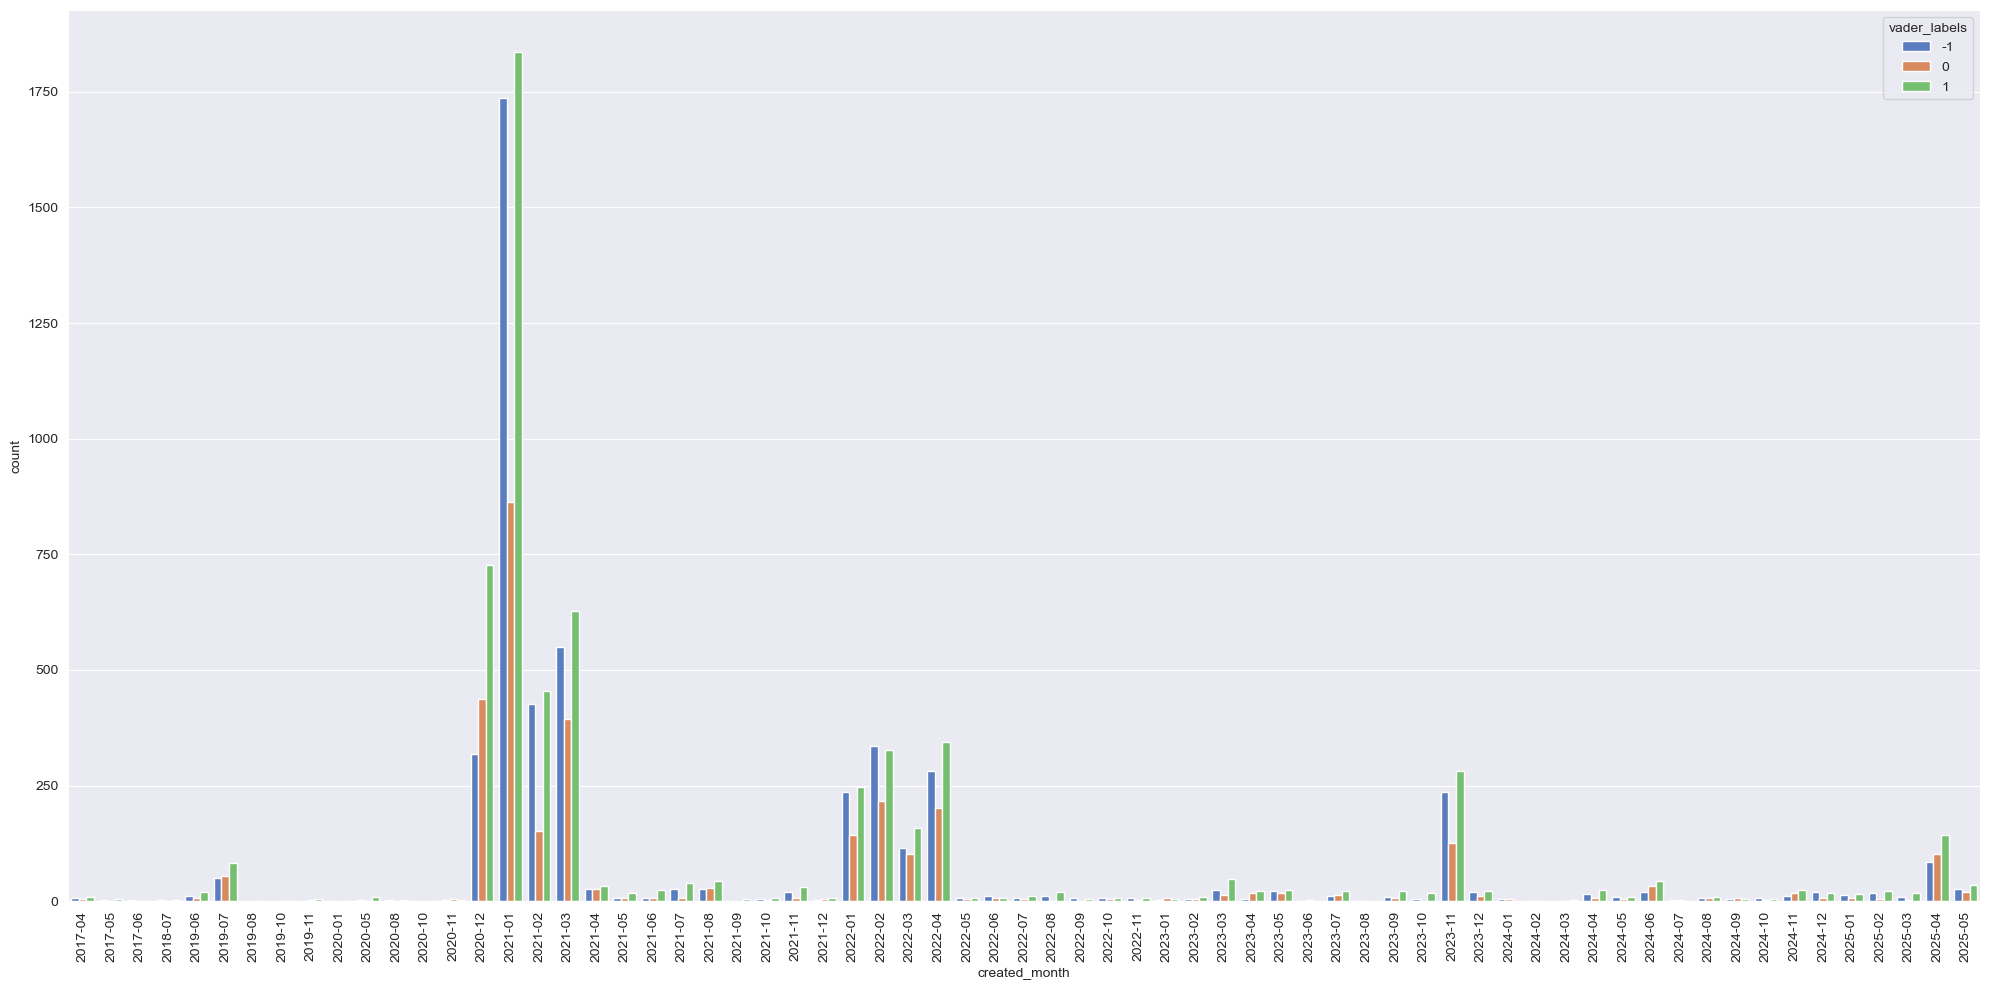

In [25]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=90)
sns.countplot(df_ending_comments, x="created_month", hue="vader_labels", palette="muted")

plt.tight_layout()
plt.show()

### Sentiment Analysis: Machine Learning

In [26]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [27]:
torch.cuda.empty_cache()

In [28]:
index_to_label_map = {
    0: -2,
    1: -1,
    2: 0,
    3: 1,
    4: 2
}

def model_sentiment_score(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        batch_results = [index_to_label_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]
        results.extend(batch_results)
    return results

df_ending_comments["model_score"] = model_sentiment_score(df_ending_comments["text_comment"].to_list())

In [31]:
df_ending_comments["model_labels"] = df_ending_comments["model_score"].apply(label_mapping, args=(0,0))
df_ending_comments["model_labels"].value_counts()

model_labels
 1    5197
-1    4542
 0    4265
Name: count, dtype: int64

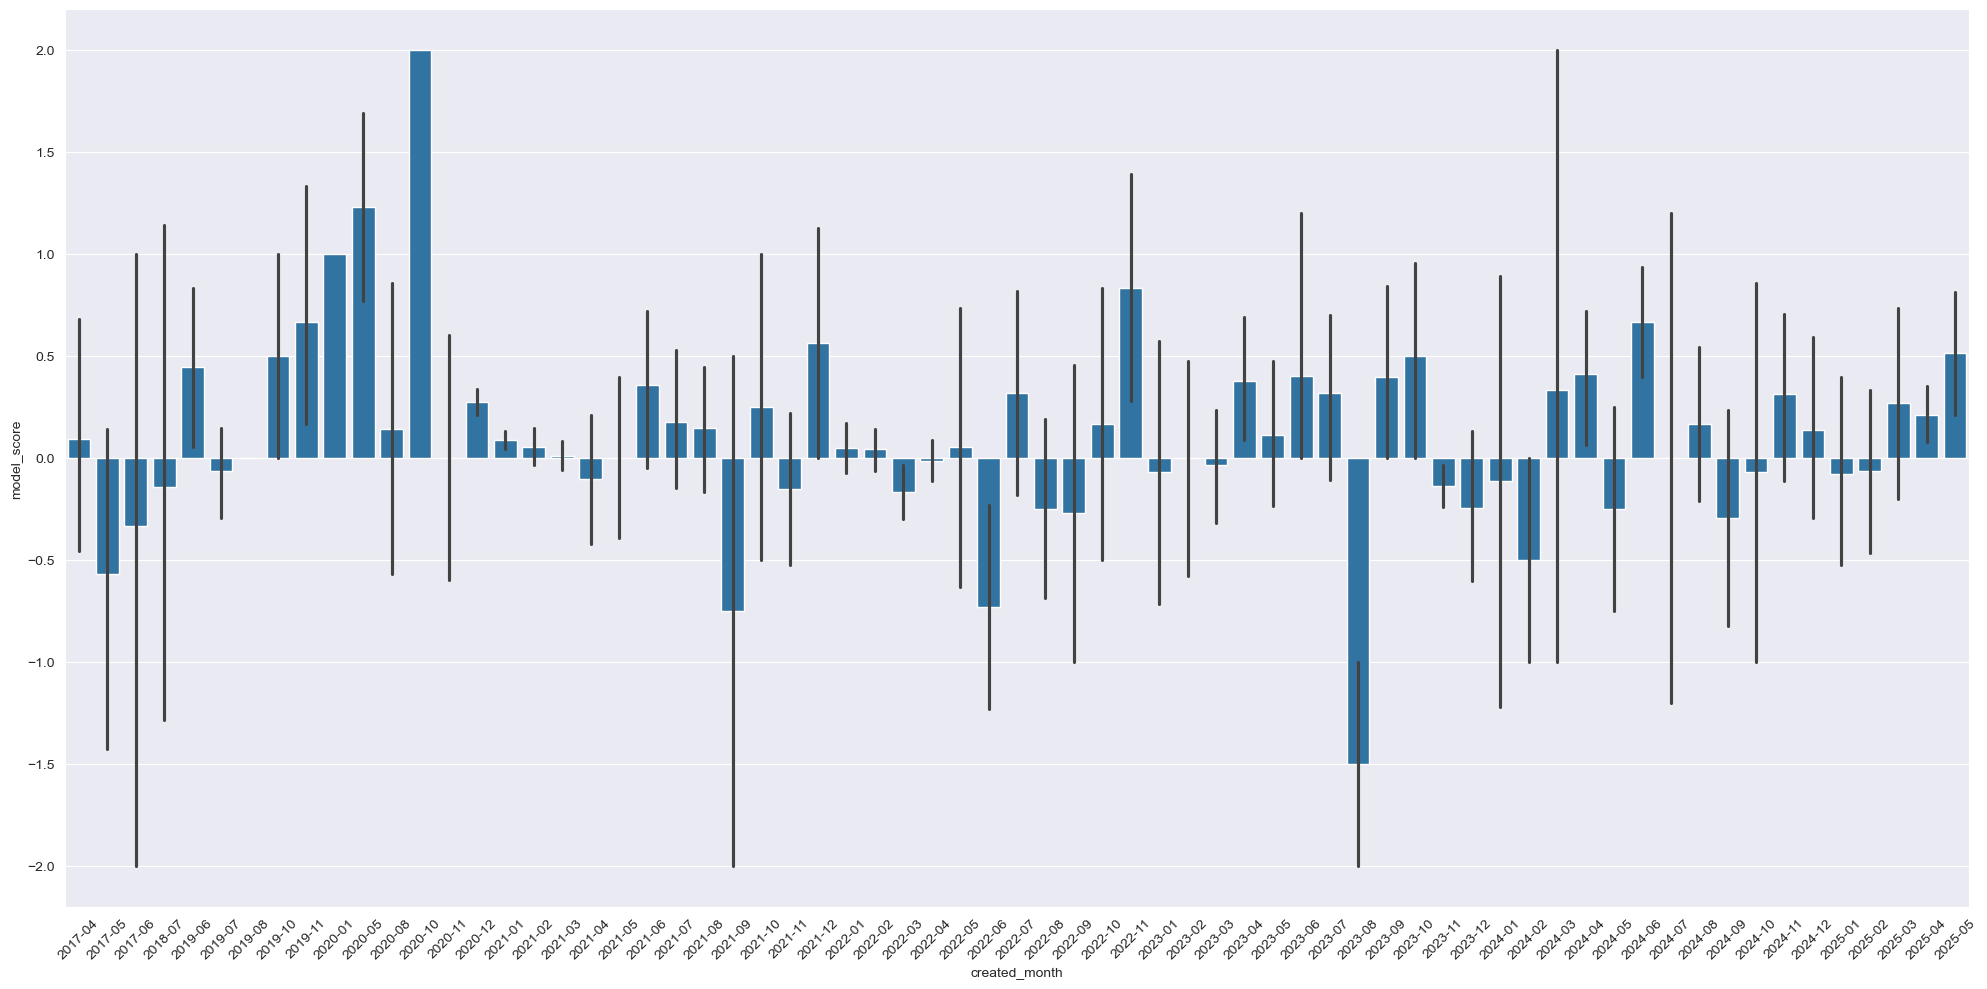

In [29]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=45)
sns.barplot(df_ending_comments[["created_month", "model_score"]], x="created_month", y="model_score", estimator="mean")

plt.tight_layout()
plt.show()

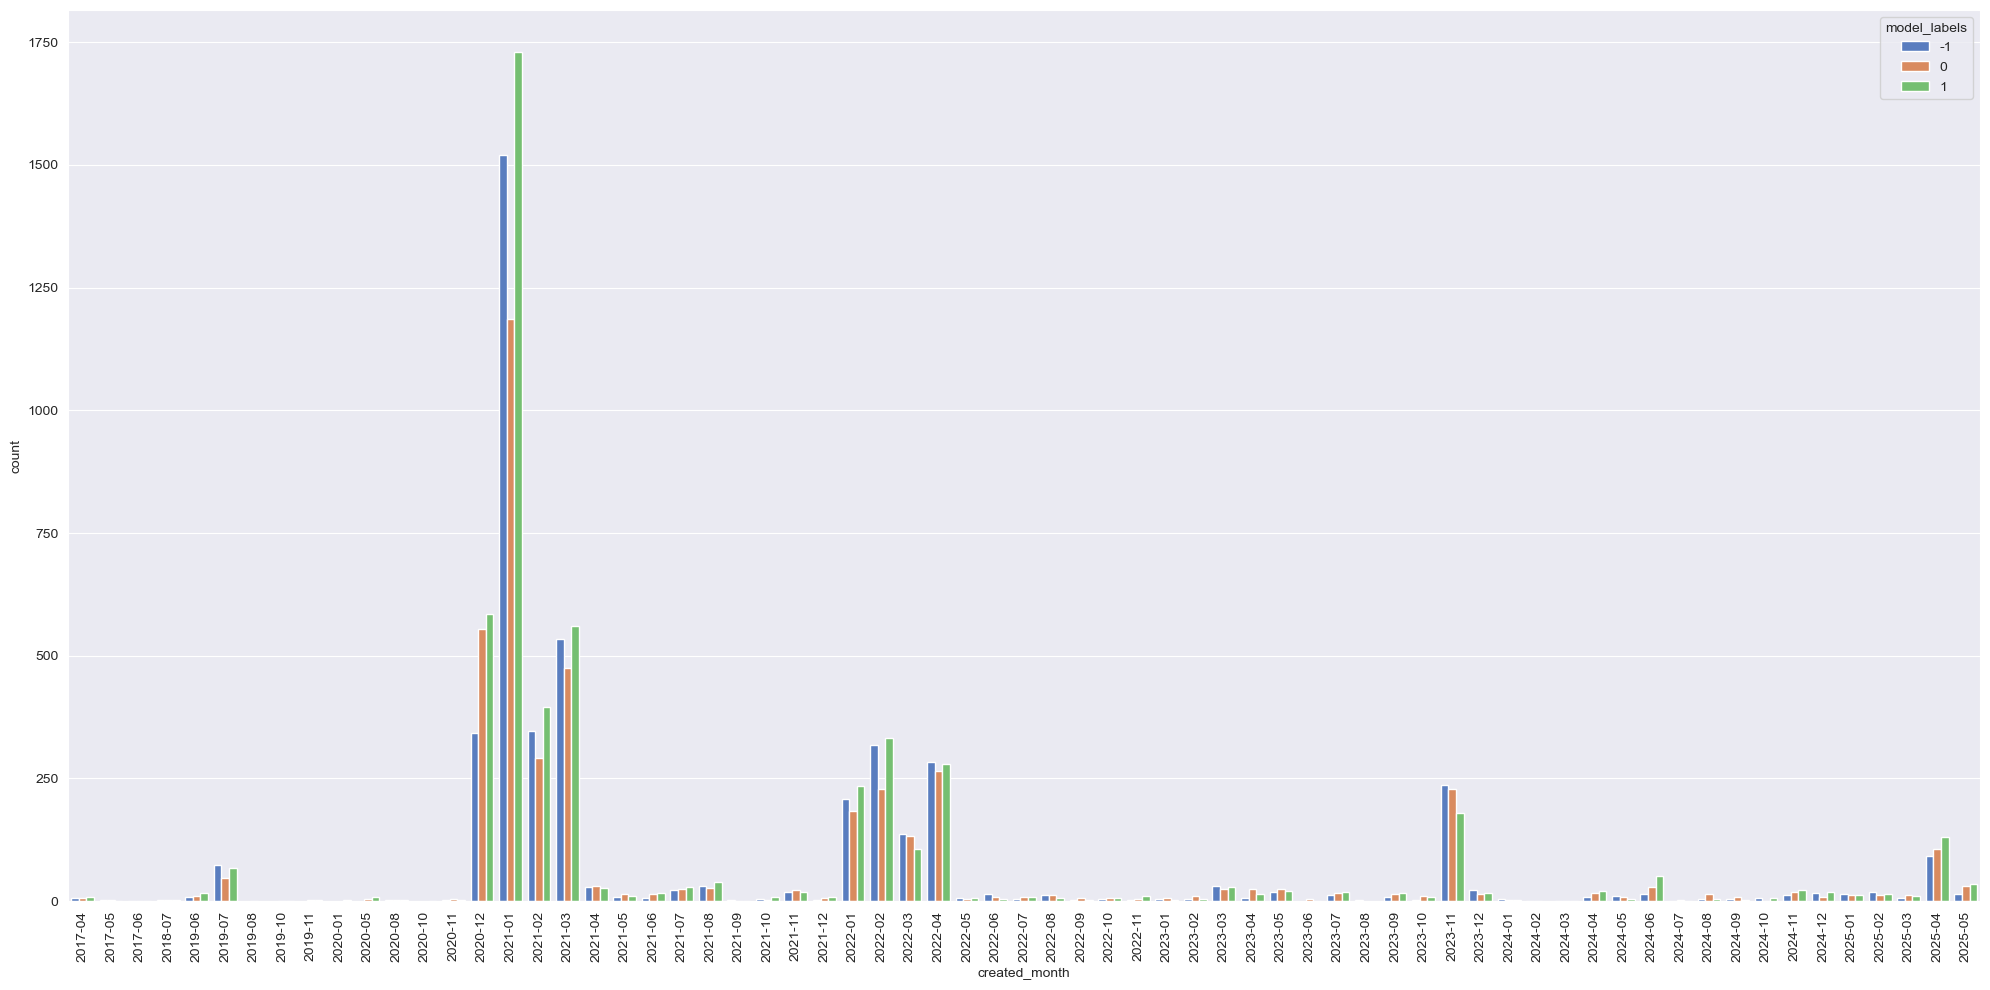

In [32]:
plt.figure(figsize=(20, 10))
plt.locator_params(axis='x', nbins=50)
plt.xticks(rotation=90)
sns.countplot(df_ending_comments, x="created_month", hue="model_labels", palette="muted")

plt.tight_layout()
plt.show()

In [33]:
df_ending_comments.to_csv("../data/comments_graph_ending_final_wscores.csv")